# Denoising filter testing
## required libaries

In [1]:
import os, time, cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from scipy.ndimage import median_filter

##remove root windows
#import tkinter as tk
#from tkinter import filedialog
#root = tk.Tk()
#root.withdraw()

home_dir = os.path.abspath("")

## load file

In [2]:
#filepath_noisy = filedialog.askopenfilename(title='Please select the image',filetypes=[("Tiff images", "*.tif;*.tiff")])
tiff_file  = home_dir + os.sep + '84d tiff.tif'
dataset = tifffile.imread(tiff_file)

In [3]:
z = dataset.shape[0]
h = dataset.shape[1]
w = dataset.shape[2]
print( "Dimensions: z = {:d}, h = {:d}, w = {:d} [px]".format(z, h, w) )


Dimensions: z = 1510, h = 1905, w = 1908 [px]


## Show the loaded images

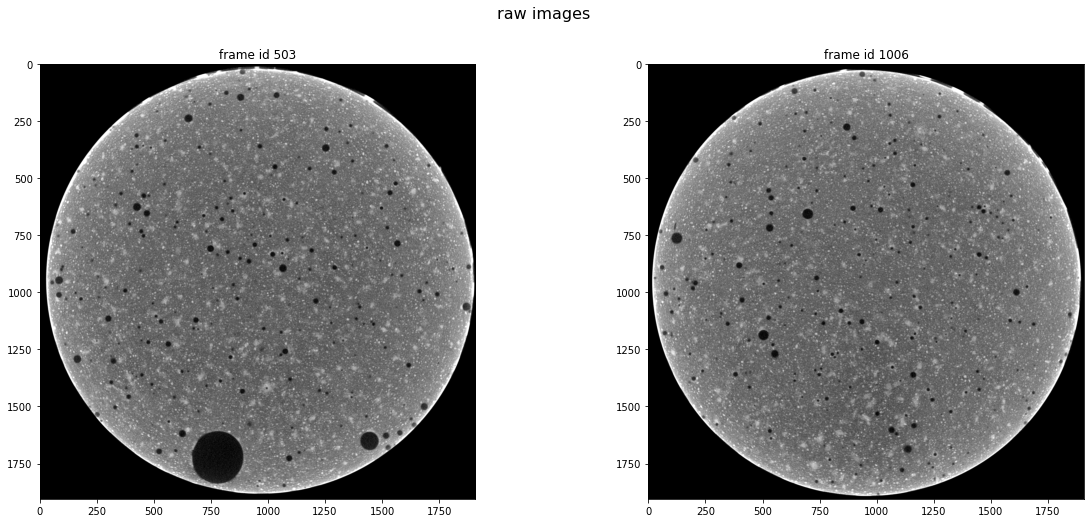

In [4]:
fig, ax = plt.subplots(1,2, figsize=(20, 8))
fig.suptitle('raw images', fontsize=16)

ax[0].imshow(dataset[int(z/3)], cmap='gray')
ax[0].set_title( "frame id {:d}".format(int(z/3)) )

ax[1].imshow(dataset[int(z/3*2)], cmap='gray')
ax[1].set_title( "frame id {:d}".format(int(z/3*2)) )

plt.show()

## process the main circle and the inner pores

In [5]:
slice	= dataset[int(z/3*2)]
thresh_v1 = 20
thresh_v2 = 70

blur = cv2.GaussianBlur(slice,(11,11),0)
ret,thresh1 = cv2.threshold( blur, thresh_v1, 255, cv2.THRESH_BINARY_INV )
ret,thresh2 = cv2.threshold( blur, thresh_v2, 255, cv2.THRESH_BINARY_INV )

edges = cv2.bitwise_not(thresh1)
#edges = cv2.Canny(blur,thresh,thresh*2)
contour, hierarchy = cv2.findContours( edges, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE )
for cnt in contour:
    cv2.drawContours(edges,[cnt],0,255,-1)
main_circle = cv2.bitwise_not(edges)

inner_pores = (thresh2-main_circle)/255

median = np.median( slice )

removed_pores = slice * np.logical_not(inner_pores) + inner_pores * median

## get center point

In [6]:
#cnts = cv2.findContours( cv2.bitwise_not(main_circle), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE )
#cnts = imutils.grab_contours(cnts)

M = cv2.moments(edges)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
print( cX, cY )
cv2.circle(main_circle, (cX, cY), 3, (255, 255, 255), -1)

954 956


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

## show images

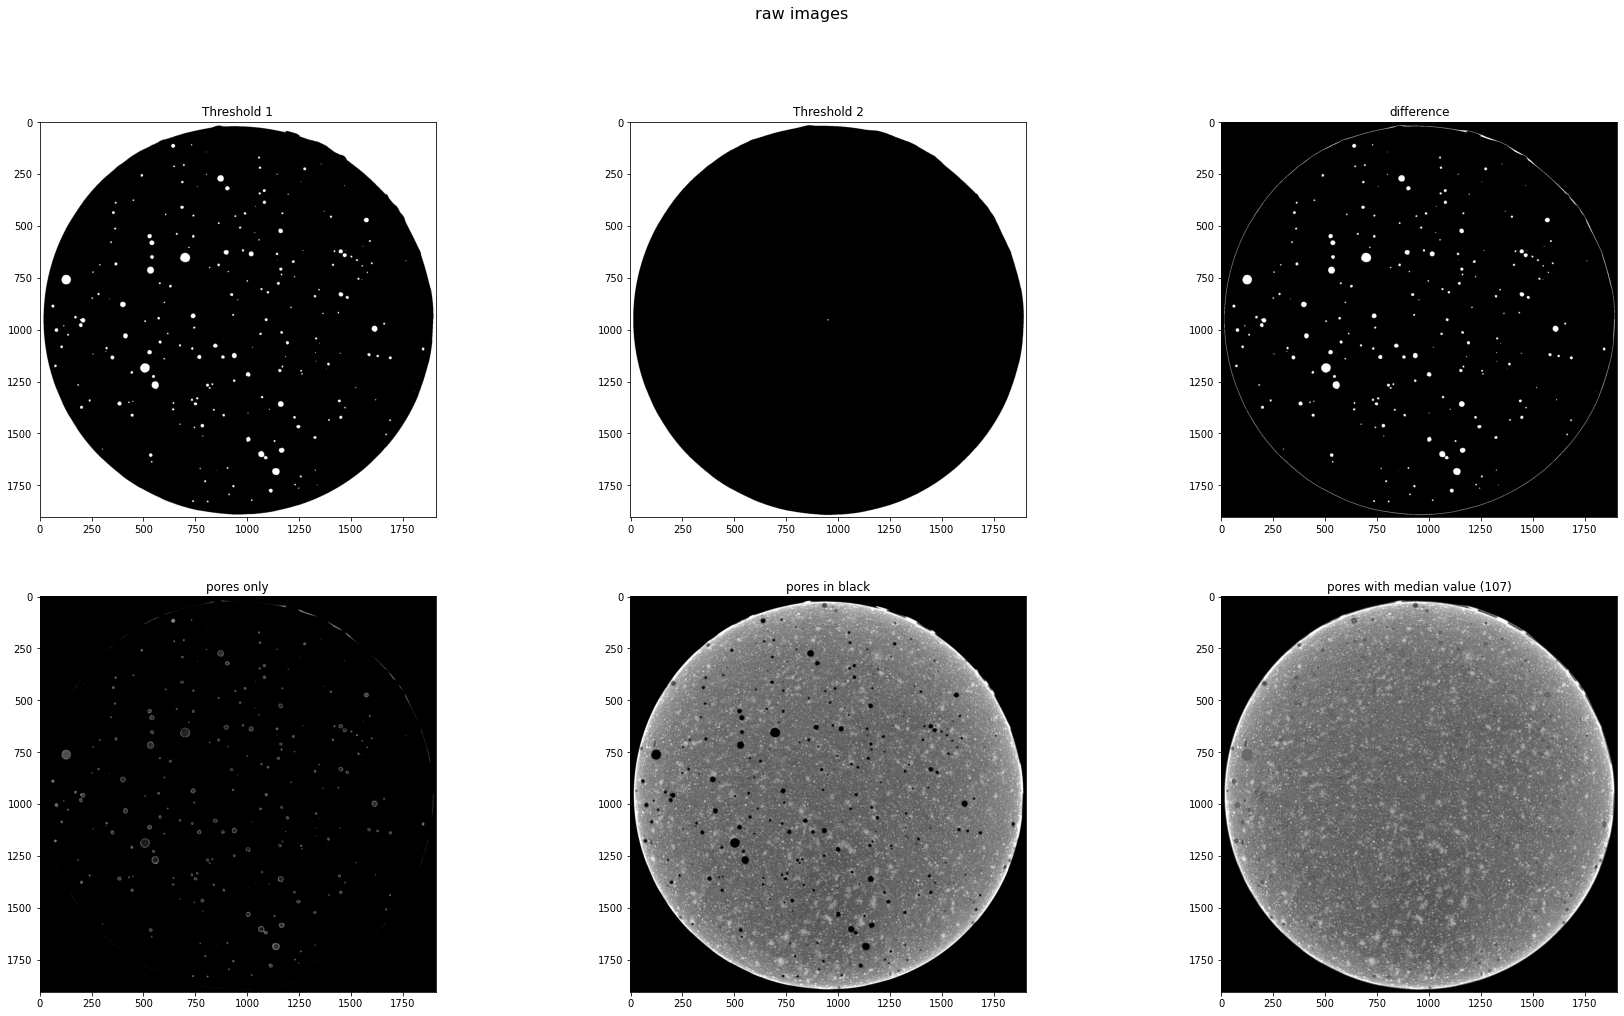

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(30, 16))
fig.suptitle('raw images', fontsize=16)

ax[0, 0].imshow( thresh2, cmap='gray' )
ax[0, 0].set_title( "Threshold 1" )

ax[0, 1].imshow( main_circle, cmap='gray')
ax[0, 1].set_title( "Threshold 2" )

ax[0, 2].imshow( inner_pores*np.median( dataset[int(z/3*2)] ), cmap='gray' )
ax[0, 2].set_title( "difference" )

ax[1, 0].imshow( slice * inner_pores, cmap='gray' )
ax[1, 0].set_title( "pores only" )

ax[1, 1].imshow( slice * np.logical_not(inner_pores), cmap='gray' )
ax[1, 1].set_title( "pores in black" )

ax[1, 2].imshow( removed_pores , cmap='gray' )
ax[1, 2].set_title( "pores with median value ({:.0f})".format(median) )

plt.show()
print()

In [8]:
def createLineIterator(P1, P2, img):
	"""
	Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

	Parameters:
		-P1: a numpy array that consists of the coordinate of the first point (x,y)
		-P2: a numpy array that consists of the coordinate of the second point (x,y)
		-img: the image being processed

	Returns:
		-it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])     
	"""
	#define local variables for readability
	imageH = img.shape[0]
	imageW = img.shape[1]
	P1X = P1[0]
	P1Y = P1[1]
	P2X = P2[0]
	P2Y = P2[1]

	#difference and absolute difference between points
	#used to calculate slope and relative location between points
	dX = P2X - P1X
	dY = P2Y - P1Y
	dXa = np.abs(dX)
	dYa = np.abs(dY)

	#predefine numpy array for output based on distance between points
	itbuffer = np.empty(shape=(np.maximum(dYa,dXa),2),dtype=np.uint16)
	itbuffer.fill(np.nan)
	print('-',len(itbuffer))

	#Obtain coordinates along the line using a form of Bresenham's algorithm
	negY = P1Y > P2Y
	negX = P1X > P2X
	if P1X == P2X: #vertical line segment
		itbuffer[:,0] = P1X
		if negY:
			itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
		else:
			itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
	elif P1Y == P2Y: #horizontal line segment
		itbuffer[:,1] = P1Y
		if negX:
			itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
		else:
			itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
	else: #diagonal line segment
		steepSlope = dYa > dXa
		if steepSlope:
			slope = dX.astype(np.float32)/dY.astype(np.float32)
			if negY:
				itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
			else:
				itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
			itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(int) + P1X
		else:
			slope = dY.astype(np.float32)/dX.astype(np.float32)
			if negX:
				itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
			else:
				itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
			itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(int) + P1Y

	#Remove points outside of image
	colX = itbuffer[:,0]
	colY = itbuffer[:,1]
	itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

	valbuffer = np.empty(shape=(len(itbuffer),1),dtype=np.float32)
	valbuffer.fill(np.nan)
	print(len(itbuffer), len(valbuffer))
	#Get intensities from img ndarray
	valbuffer[:,0] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

	return valbuffer, itbuffer

In [9]:
min_length = np.array( [cY, h-cY, cX, w-cX] ).min()
print(min_length)

from skimage.draw import line as skidline


def get_linepnts(p0, p1, img):
	p0, p1 = np.array(p0).flatten(), np.array(p1).flatten()
	l0 = np.array(list(zip(*skidline(p0[0],p0[1], p1[0],p1[1]))))
	#if p0/p1 are in (x,y) format, then this needs to be swapped for retrieval:
	return img[l0[:,1]-1, l0[:,0]-1]

949


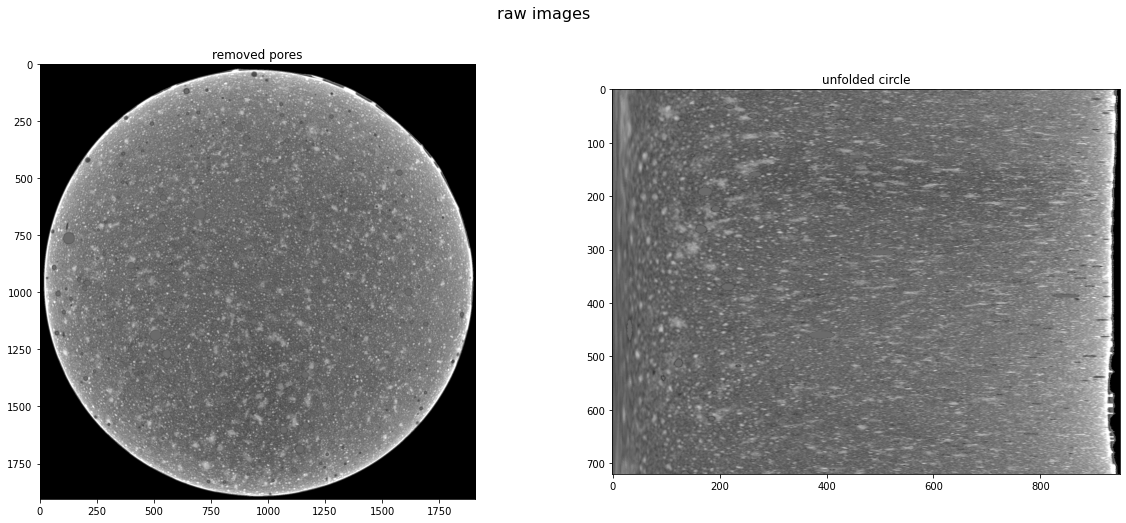

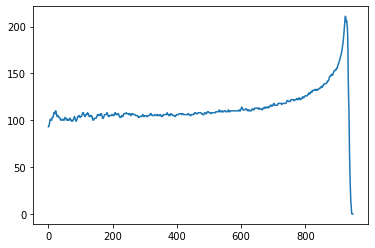

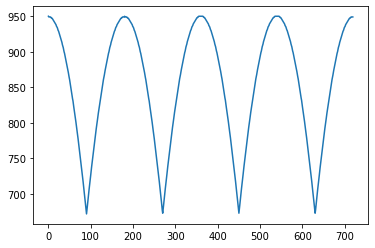

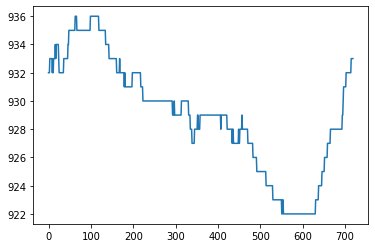

In [35]:
circle_canvas = np.empty(shape=(w,h),dtype=int)
circle_canvas.fill(0)
cv2.circle(circle_canvas, (cX, cY), 3, (255, 255, 255), -1)

angle_in_deg = 0.5
median_blur_kernel = 1

values = np.empty( shape=(int(360/angle_in_deg), min_length), dtype=np.uint8)
line_length = []
max_pos = []
for i in range(int(360/angle_in_deg)):
	a	= np.deg2rad( i*angle_in_deg )
	Xi	= ( min_length * np.cos(a) + cX ).astype(int)
	Yi	= ( min_length * np.sin(a) + cY ).astype(int)
	cv2.circle(circle_canvas, (Xi, Yi), 3, (255, 0, 0,), -1)
	#val, coord = createLineIterator( (cX, cY), (cX, 0), removed_pores )
	#val, coord = createLineIterator( (cX, cY), (Xi, Yi), removed_pores )
	# get values along two points
	v = get_linepnts((cX, cY), (Xi, Yi), removed_pores)
	line_length.append(len(v))
	# resize the line length in px
	v = cv2.resize( v, (1, min_length), interpolation = cv2.INTER_LINEAR ).astype( np.uint8 )
	values[i] = cv2.medianBlur(v, median_blur_kernel).flatten()
	max_pos.append(np.argmax(values[i]))
	
mean_values = (values.sum(0)/int(360/angle_in_deg)).astype(np.uint8)

fig, ax = plt.subplots(1,2, figsize=(20, 8))
fig.suptitle('raw images', fontsize=16)
ax[0].imshow(removed_pores, cmap='gray')
ax[0].set_title( "removed pores" )
ax[1].imshow(values, cmap='gray')
ax[1].set_title( "unfolded circle" )
plt.show()

# show the mean grey value of the circle radius
plt.plot(range(min_length), mean_values)
plt.show()

#plt.plot(range(len(line_length)), np.array(line_length))
#plt.show()

#show uncircularity
plt.plot(range(len(max_pos)), median_filter(np.array(max_pos),25 ) )
plt.show()